<a href="https://colab.research.google.com/github/srilav/neuralnetwork/blob/main/M4_NB_MiniProject_3_Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Video based Action Classification using LSTM

## Learning Objectives

At the end of the experiment, you will be able to :

* extract frames out of a video
* build the CNN model to extract features from the video frames
* train LSTM/GRU model to perform action classification 

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:

 

*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below. 

![img](http://www.nada.kth.se/cvap/actions/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:** 

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN; 
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file; 
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability; 
Label the frame and write the output frame to disk

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video

## Grading = 10 Points

In [ ]:
#@title Download Dataset
#!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
#!unzip -qq Actions.zip
#print("Dataset downloaded successfully!!")
print("Dataset will be mounted from GDrive")

Dataset will be mounted from GDrive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
main_path = '/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions'

Mounted at /content/gdrive


### Folder Structure

Folder structure is like this
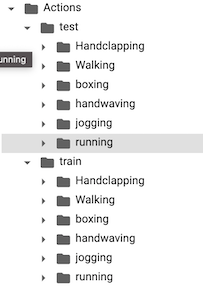

### Import required packages

In [ ]:
!pip install sk-video
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.datasets import load_files
from skvideo.io import FFmpegReader, ffprobe
from skvideo.utils import rgb2gray
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from tensorflow_docs.vis import embed
from imutils import paths

import tensorflow as tf
import pandas as pd
import imageio

# How to process videos?

Spatial refers to space. Temporal refers to time. Spatiotemporal, or spatial temporal, is used in data analysis when data is collected across both space and time. It describes a phenomenon in a certain location and time — for example, shipping movements across a geographic area over time. A person uses spatial-temporal reasoning to solve multi-step problems by envisioning how objects move in space and time.


---


A video consists of an ordered sequence of frames. Each frame contains *spatial information*, and the sequence of those frames contains *temporal information*. To model both of these aspects, we use a hybrid architecture that consists of convolutions (for spatial processing) as well as recurrent layers (for temporal processing). Specifically, we'll use a Convolutional Neural Network (CNN) and a Recurrent Neural Network (RNN) consisting of [GRU layers](https://keras.io/api/layers/recurrent_layers/gru/). This kind of hybrid architecture is popularly known as a **CNN-RNN**.



---


The steps below explain how videos are processed. ([Source](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77))
- Save the filepath of each video and corresponding labels in the form of a DataFrame
- Start by reading the videos in order using OpenCV. Read each video by specifying the FPS as 1
- Save those frames read from each video in a folder specified for that video
- Read 10 frames from each video and load them in a Numpy Array as tensors to be fed into a NN
- Design a NN model and train it on the data

**However, the implementation below do not follow the steps listed above as the number of frames are > 300 (on an average) and by reading 10 frames from each video, we can barely understand anything.**

### Load the data and generate frames of video (2 points)

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [ ]:
#train_data_dir = "/content/Actions/train/"
#test_data_dir = "/content/Actions/test/"
# YOUR CODE HERE
train_data_dir = os.path.join(main_path, "train/")
test_data_dir =  os.path.join(main_path, "test/")

In [ ]:
class_names = os.listdir(train_data_dir)
class_names

['Walking', 'running', 'jogging', 'handwaving', 'boxing', 'Handclapping']

Removing an outlier video file that is causing exceptions to be thrown when running some video processing

In [ ]:
#os.remove('/content/Actions/train/boxing/person01_boxing_d4_uncomp.avi')
os.remove(train_data_dir + 'boxing/person01_boxing_d4_uncomp.avi')

#### Utility Functions for Video Processing

In [ ]:
required_fps = None
to_gray = False
target_size = None
max_frames = None
extract_frames = None
normalize_pixels = None

In [ ]:
def process_video(video):
        """
        Parameters:
            video (Numpy.ndarray):
                Shape = (<No. of frames>, <height>, <width>, <channels>)
                Video whose frames are to be extracted
        Returns:
            Numpy.ndarray
                A tensor (processed video) with shape (<`max_frames`>, <height>, <width>, <channels>)
        """

        total_frames = video.shape[0]
        if max_frames <= total_frames:
            if extract_frames == 'first':
                video = video[:max_frames]
            elif extract_frames == 'last':
                video = video[(total_frames - max_frames):]
            elif extract_frames == 'middle':
                # No. of frames to remove from the front
                front = ((total_frames - max_frames) // 2) + 1
                video = video[front:(front + max_frames)]
            else:
                raise ValueError('Invalid value of \'extract_frames\'')

        else:
            raise IndexError(
                'Required number of frames is greater than the total number of frames in the video')

        return video

In [ ]:
def read_single_video(path):
        """
        Parameters:
            path (str): Required
                Path of the video to be read
        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (1, <No. of frames>, <height>, <width>, <channels>)
        """

        cap = FFmpegReader(filename=path)
        list_of_frames = []
        fps = int(cap.inputfps) # Frame Rate

        for index, frame in enumerate(cap.nextFrame()):
            capture_frame = True
            if required_fps != None:
                is_valid = range(required_fps)
                capture_frame = (index % fps) in is_valid

            if capture_frame:
                if target_size is not None:
                    try:
                      temp_image = image.array_to_img(frame)
                    except Exception as e:
                      print('exception in array_to_img')
                    try:
                      frame = image.img_to_array(
                        temp_image.resize(
                            target_size,
                            Image.ANTIALIAS)).astype('uint8')
                    except Exception as e:
                      print('exception in resize')

                # Shape of each frame -> (<height>, <width>, 3)
                list_of_frames.append(frame)

        temp_video = np.stack(list_of_frames)
        cap.close()

        if to_gray:
            temp_video = rgb2gray(temp_video)
                
        if max_frames is not None:
            temp_video = process_video(video=temp_video)

        return np.expand_dims(temp_video, axis=0)

In [ ]:
def read_videos(paths, 
                v_target_size=None, 
                v_to_gray=True, 
                v_max_frames=None, 
                v_extract_frames='middle', 
                v_required_fps=None,
                v_normalize_pixels=None):
        """
        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read
        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (<No. of Videos>, <No. of frames>, <height>, <width>, <channels>)
        """

        required_fps = v_required_fps
        to_gray = v_to_gray
        target_size = v_target_size
        max_frames = v_max_frames
        extract_frames = v_extract_frames
        normalize_pixels = v_normalize_pixels

        list_of_videos = [
            read_single_video(path) for path in tqdm(paths)
        ]

        tensor = np.column_stack(list_of_videos)

        if normalize_pixels != None:
            # Pixels are normalized for each video individually
            if (type(normalize_pixels) == tuple) and (len(normalize_pixels) == 2):
                base = normalize_pixels[0]
                r = normalize_pixels[1] - base
                min_ = np.min(tensor, axis=(1, 2, 3), keepdims=True)
                max_ = np.max(tensor, axis=(1, 2, 3), keepdims=True)
                return ((tensor.astype('float32') - min_) / (max_ - min_)) * r + base

            elif normalize_pixels == 'z-score':
                mean = np.mean(tensor, axis=(1, 2, 3), keepdims=True)
                std = np.std(tensor, axis=(1, 2, 3), keepdims=True)
                return (tensor.astype('float32') - mean) / std
            
            else:
                raise ValueError('Invalid value of \'normalize_pixels\'')

        return tensor

In [ ]:
def get_frame_count(paths):
        """
        Can be used to determine the value of `max_frames`
        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read
        Returns:
            dict (python dictionary)
                For each video, the total number of frames in that video is stored in the dictionary.
        """

        frame_count = {}
        for path in paths:
            cap = FFmpegReader(filename=path)
            frame_count[path] = cap.inputframenum
            cap.close()

        return frame_count

In [ ]:
# Loading the data
raw_data = load_files(train_data_dir, shuffle=False)
files = raw_data['filenames']
targets = raw_data['target']

### Understanding the folder structure and the files

In [ ]:
print('The mapping between video classes (categories) and integers are - \n')
for label in zip(range(6), raw_data['target_names']):
    print(label)

The mapping between video classes (categories) and integers are - 

(0, 'Handclapping')
(1, 'Walking')
(2, 'boxing')
(3, 'handwaving')
(4, 'jogging')
(5, 'running')


In [ ]:
# Displaying the first 5 videos (paths) in the dataset along with their labels
# (path of video, class label)
for pair in zip(files[:5], targets[:5]):
    print(pair)

('/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person01_handclapping_d1_uncomp.avi', 0)
('/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person01_handclapping_d2_uncomp.avi', 0)
('/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person01_handclapping_d3_uncomp.avi', 0)
('/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person01_handclapping_d4_uncomp.avi', 0)
('/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person02_handclapping_d1_uncomp.avi', 0)


In [ ]:
# The path of a sample video in the training data
sample_files = files[:1]

# Loading the sample videos, in their original format
sample = read_videos(sample_files)
print('\nShape of the sample data:', sample.shape)

100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Shape of the sample data: (1, 378, 120, 160, 3)


The shape of the tensor obtained is **(1, 378, 120, 160, 3)**.

This indicates that:
* There is **1** video
* The video has **378** frames
* The dimension of each frame is **120x160** pixels
* There are **3** channels for each frame - Red(R), Green(G) and Blue(B)



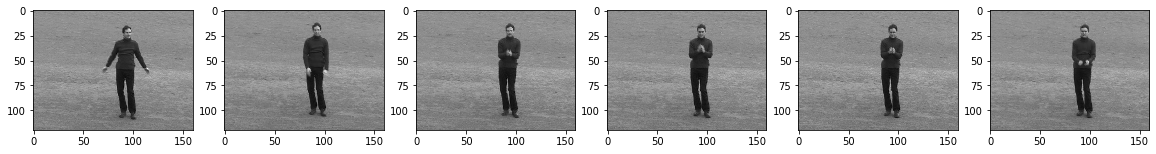

In [ ]:
plt.figure(figsize = (20, 30))
frame_pointers_array = [50, 100, 150, 200, 300, 350]
cnt = 1
for frame in frame_pointers_array:
  plt.subplot(1, 6, cnt)
  cnt += 1
  plt.imshow(sample[0][frame])

In [ ]:
# Print the # of frames in a sample set of videos
get_frame_count(files[:10])

{'/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person01_handclapping_d1_uncomp.avi': 378,
 '/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person01_handclapping_d2_uncomp.avi': 550,
 '/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person01_handclapping_d3_uncomp.avi': 428,
 '/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person01_handclapping_d4_uncomp.avi': 390,
 '/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person02_handclapping_d1_uncomp.avi': 398,
 '/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person02_handclapping_d2_uncomp.avi': 390,
 '/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person02_handclapping_d3_uncomp.avi': 385,
 '/content/gdrive/MyDrive/ML-Projects/Video-Classification/Actions/train/Handclapping/person02_ha

As seen above, the number of frames in each video is not the same. In order to stack the videos in a tensor, each video should have the same number of frames. Therefore, we would have to select the same number of frames from each video.

### Visualize the frames and analyze the object in each frame. (1 point)

* Plot the frames of each class per row (6 rows)
* Plot the title as label on each subplot




In [ ]:
subset_files = files[1:100]

In [ ]:
X_train = read_videos(subset_files, v_target_size=(128, 128), 
                v_to_gray=True, 
                v_max_frames=300, 
                v_extract_frames='middle', 
                v_normalize_pixels=(0, 1))
y_train = to_categorical(targets, num_classes=6)

print('Shape of training data:', X_train.shape)
print('Shape of training labels:', y_train.shape)

100%|██████████| 99/99 [00:29<00:00,  3.31it/s]


### Create the Neural Network (4 points)

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat as a time series.
* Apply a DenseNet to take the decision and classify.

##### Build the ConvNet for the feature extraction, GRU LSTM layers as a time series and Dense layers for classification

In [ ]:
# YOUR CODE HERE

#### Setup the parameters and train the model with epochs, batch wise 

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
# Note: There will be a high memory requirement for the training steps below. 
# You should work on a GPU/TPU based runtime. See 'Change Runtime' in Colab
# Training time for each epoch could be ~30 mins
# To save and re-load your model later, see the reference below:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

# YOUR CODE HERE

### Use pre-trained model for feature extraction (3 points)

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

#### Load and fine-tune the pre-trained model

In [ ]:
# YOUR CODE HERE

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
# YOUR CODE HERE

### Report Analysis

* Discuss on FPS, Number of frames and duration of each video
* Analyze the impact of the LSTM, GRU and TimeDistributed layers
* Discuss about the model convergence using pre-trained and ConvNet
* *Additional Reading*: Read and discuss about the use of ([Conv3D](https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5)) in video classification